# CROPPING T1 AND FLAIR AROUND TUMOR IN CANCER DATASETS

In [61]:
import os
from os.path import join
import nibabel as nib
from nilearn.plotting import plot_anat
import pandas as pd
import numpy as np
from tqdm import tqdm

DATA =  "data/MR"


def ls_dir(path):
    dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    return dirs

def find_tumor_limits(mask):
    mask = mask.get_fdata()
    W, H, D = mask.shape
    x_limits = [x for x in range(W) if mask[x, :, :].sum().item() > 0]
    y_limits = [y for y in range(H) if mask[:, y, :].sum().item() > 0]
    z_limits = [z for z in range(D) if mask[:, :, z].sum().item() > 0]

    center = (
        int((x_limits[-1] + x_limits[0])/2),
        int((y_limits[-1] + y_limits[0])/2),
        int((z_limits[-1] + z_limits[0])/2)
        )
    
    minX, maxX = x_limits[0], x_limits[-1]
    minY, maxY = y_limits[0], y_limits[-1]
    minZ, maxZ = z_limits[0], z_limits[-1]

    bbox = [(minX, maxX), (minY,maxY), (minZ, maxZ)]

    return center, bbox

## Create a dataframe containing all tumor dimensions and coordinates

In [ ]:
tumor_sizes = pd.DataFrame()

os.chdir("/home/tbarba/projects/MultiModalBrainSurvival/")

DATASET = {
    "UCSF": "SegmBinary.nii.gz",
    "TCGA": "GlistrBoostBinary.nii.gz",
    "UPENN": "SegmBinary.nii.gz"}

for dataset, segm_mod in DATASET.items():
    df = pd.DataFrame()
    df["DATASET"] = dataset

    images_path = join(DATA, dataset, "images")
    eids = [c for c in ls_dir(images_path)]
    
    for eid in eids:
        eid_path = join(images_path, eid)
        segm = join(eid_path, segm_mod)

        segm = nib.load(segm)
        center, bbox = find_tumor_limits(segm)

        bbox = np.array(bbox).flatten()
        bbox = pd.Series(bbox, name=eid)
        df = df.append(bbox)

    df.columns= ["DATASET", "minX", "maxX","minY","maxY", "minZ", "maxZ"]

    df["WIDTH"] = df.maxX - df.minX
    df["HEIGHT"] = df.maxY - df.minY
    df["DEPTH"] = df.maxZ - df.minZ
    df["DATASET"] = dataset

    final_df = pd.concat([final_df, df], axis=0)

tumor_sizes.to_csv("/home/tbarba/projects/MultiModalBrainSurvival/data/MR/UCSF/tumor_sizes.csv", index=True)

In [3]:
tumor_sizes

,DATASET,minX,maxX,minY,maxY,minZ,maxZ,WIDTH,HEIGHT,DEPTH
UCSF-PDGM-0004,UCSF,139.0,182.0,133.0,182.0,81.0,126.0,43.0,49.0,45.0
UCSF-PDGM-0005,UCSF,63.0,111.0,105.0,158.0,59.0,116.0,48.0,53.0,57.0
UCSF-PDGM-0007,UCSF,51.0,130.0,68.0,177.0,46.0,124.0,79.0,109.0,78.0
UCSF-PDGM-0008,UCSF,58.0,123.0,91.0,191.0,52.0,129.0,65.0,100.0,77.0
UCSF-PDGM-0009,UCSF,119.0,177.0,54.0,139.0,79.0,143.0,58.0,85.0,64.0
...,...,...,...,...,...,...,...,...,...,...
UPENN-GBM-00607_11,UPENN,118.0,179.0,53.0,171.0,41.0,113.0,61.0,118.0,72.0
UPENN-GBM-00608_11,UPENN,123.0,182.0,86.0,165.0,34.0,97.0,59.0,79.0,63.0
UPENN-GBM-00609_11,UPENN,66.0,134.0,111.0,183.0,6.0,60.0,68.0,72.0,54.0
UPENN-GBM-00610_11,UPENN,120.0,141.0,112.0,135.0,93.0,118.0,21.0,23.0,25.0


## Calculate maximum tumor box size based on the dataframe.


68 94 75


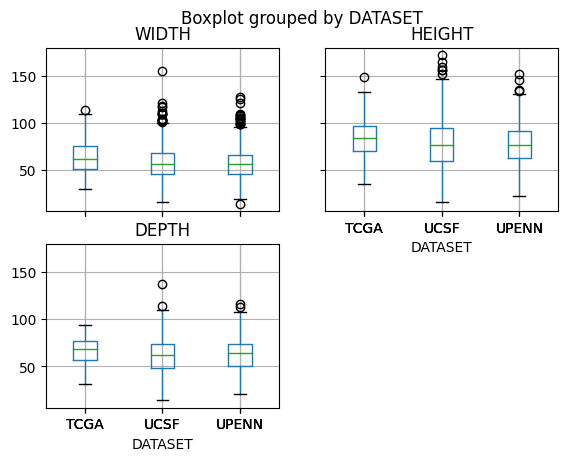

In [15]:
tumor_sizes.boxplot(column=["WIDTH","HEIGHT","DEPTH"], by="DATASET")

width_3qt = int(tumor_sizes.WIDTH.quantile([0.75]))
height_3qt = int(tumor_sizes.HEIGHT.quantile([0.75]))
depth_3qt = int(tumor_sizes.DEPTH.quantile([0.75]))
print(width_3qt, height_3qt, depth_3qt)


## Cropping modalities around tumor

For each case :

    - import T1 and FLAIR modalities.
    - import tumor segmentation
    - Find center coordinates
    - Define bbox based on the center
    - Crop T1 and FLAIR with the bbox (Image.slicer)
    - Export the new cropped files

In [60]:
def import_modality(path, pattern):
    files = os.listdir(path)
    mod = [f for f in files if f"{pattern.lower()}.nii" in f.lower()][0]
    mod = join(eid_path, mod)

    mod = nib.load(mod)

    return mod


def crop_nifti(nifti, center, bbox_dim):

    width, height, depth = bbox_dim

    maxX, maxY, maxZ = nifti.shape
    centerX, centerY, centerZ = center
    
    halfw = width //2
    halfh = height //2
    halfd = depth //2

    lowX = max(centerX - halfw, 0)
    highX = min(centerX + halfw, maxX)
    # lowX = maxX - halfw * 2 if highX == maxX else lowX
    # highX = halfw * 2 if lowX ==0 else highX
    
    lowY = max(centerY - halfh, 0)
    highY = min(centerY + halfh, maxY)
    # lowY = maxY - halfh * 2 if highY == maxY else lowY
    # highY = halfh * 2 if lowY ==0 else highY


    lowZ = max(centerZ - halfd, 0)
    highZ = min(centerZ + halfd, maxZ)
    # lowZ = maxZ - halfd * 2 if highZ == maxZ else lowZ
    # highZ = halfd * 2 if lowZ ==0 else highZ

    # Slicer
    cropped_nifti = nifti.slicer[lowX:highX, lowY:highY, lowZ:highZ]

    return cropped_nifti



Créer une image croppée autour de la tumeur

In [62]:
tumor_sizes = pd.DataFrame()

os.chdir("/home/tbarba/projects/MultiModalBrainSurvival/")

DATASET = {
    "UCSF": ["T1c","FLAIR", "SegmBinary"],
    "TCGA": ["T1Gd","FLAIR", "BoostBinary"],
    "UPENN": ["T1GD","FLAIR", "SegmBinary"]
    }

BBOX_DIM = [68, 94, 75]

for dataset, modalities in DATASET.items():

    images_path = join(DATA, dataset, "images")
    eids = [c for c in ls_dir(images_path)]
    
    for eid in tqdm(eids):
        eid_path = join(images_path, eid)

        files = os.listdir(eid_path)

        t1 = import_modality(eid_path, modalities[0])
        flair = import_modality(eid_path, modalities[1])
        segm = import_modality(eid_path, modalities[2])
 
        center, bbox = find_tumor_limits(segm)
        t1_cropped = crop_nifti(t1, center, BBOX_DIM)
        flair_cropped = crop_nifti(flair, center, BBOX_DIM)
        
        nib.save(t1_cropped, join(eid_path, 'T1c_crop.nii.gz'))
        nib.save(flair_cropped, join(eid_path, 'FLAIR_crop.nii.gz'))

100%|██████████| 611/611 [08:36<00:00,  1.18it/s]


## Data augmentation sur les tumor datasets :
créer 40 images croppées autour de random centers sélectionnés dans la tumeur

In [7]:
from random import choices, seed
import os
from os.path import join
import nibabel as nib
import pandas as pd
import numpy as np
from tqdm import tqdm

tumor_sizes = pd.DataFrame()

seed(1)



os.chdir("/home/tbarba/projects/MultiModalBrainSurvival/")
DATA =  "data/MR"

DATASET = {
    "UCSF": ["T1c", "FLAIR", "SegmBinary"],
    # "TCGA": ["T1Gd", "FLAIR", "BoostBinary"],
    # "UPENN": ["T1GD", "FLAIR", "SegmBinary"]
}

BBOX_DIM = [68, 94, 75]
NUM_CENTERS = 20
OUTPUT_DIR = join(DATA, "UCSF/augmented/images")


def ls_dir(path):
    dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    return dirs



def import_modality(path, pattern):
    files = os.listdir(path)
    mod = [f for f in files if f"{pattern.lower()}.nii" in f.lower()][0]
    mod = join(eid_path, mod)

    mod = nib.load(mod)

    return mod


def crop_nifti(nifti, center, bbox_dim):

    width, height, depth = bbox_dim

    maxX, maxY, maxZ = nifti.shape
    centerX, centerY, centerZ = center
    
    halfw = width //2
    halfh = height //2
    halfd = depth //2

    lowX = max(centerX - halfw, 0)
    highX = min(centerX + halfw, maxX)
    
    lowY = max(centerY - halfh, 0)
    highY = min(centerY + halfh, maxY)

    lowZ = max(centerZ - halfd, 0)
    highZ = min(centerZ + halfd, maxZ)

    # Slicer
    cropped_nifti = nifti.slicer[lowX:highX, lowY:highY, lowZ:highZ]

    return cropped_nifti

for dataset, modalities in DATASET.items():

    images_path = join(DATA, dataset, "images")
    eids = [c for c in ls_dir(images_path)]

    for eid in tqdm(eids):
        eid_path = join(images_path, eid)

        files = os.listdir(eid_path)

        t1 = import_modality(eid_path, modalities[0])
        flair = import_modality(eid_path, modalities[1])
        segm = import_modality(eid_path, modalities[2])

        coords = tuple(zip(*np.where(segm.get_fdata() ==1)))
        random_centers = choices(coords, k=NUM_CENTERS)
        for center in random_centers:
            x,y,z = center
            output_eid = join(OUTPUT_DIR, f"{eid}_c{x}{y}{z}")
            os.makedirs(output_eid, exist_ok=True)

            t1_cropped = crop_nifti(t1, center, BBOX_DIM)
            flair_cropped = crop_nifti(flair, center, BBOX_DIM)
            nib.save(t1_cropped, join(output_eid, 'T1c_crop.nii.gz'))
            nib.save(flair_cropped, join(output_eid, 'FLAIR_crop.nii.gz'))



100%|██████████| 494/494 [1:26:55<00:00, 10.56s/it]
